# **Denoising Diffusion Probabilistic Models with MiniAi - Part 2**

In [1]:
import pickle,gzip,math,os,time,shutil,random,logging
import fastcore.all as fc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
import warnings

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')

## **Load Dataset**

In [3]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

# We won't be converting to 32x32 this time around
# instead, all image tensors will have a default padding
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [4]:
# Setup training dl and batches 
dt = dls.train
xb, yb = next(iter(dt))

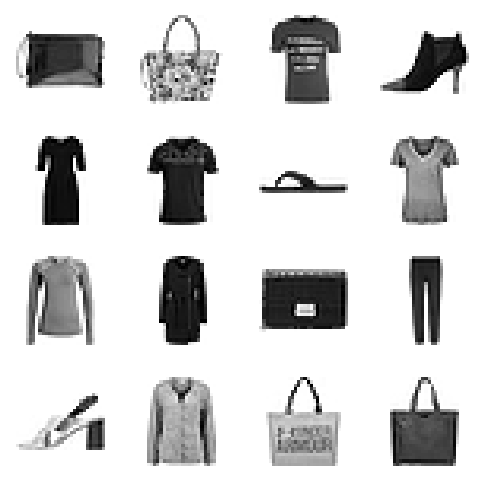

In [5]:
show_images(xb[:16], imsize=1.5)

In [6]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alpha_bar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

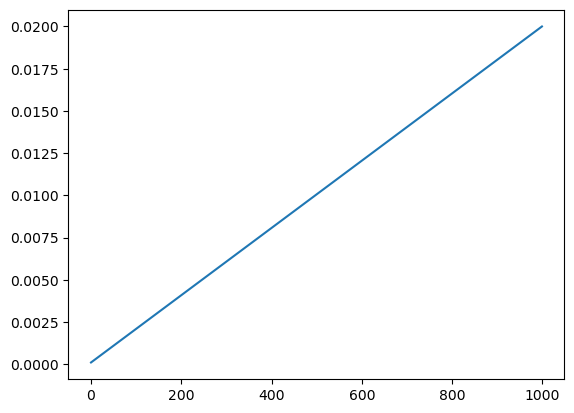

In [7]:
plt.plot(beta);

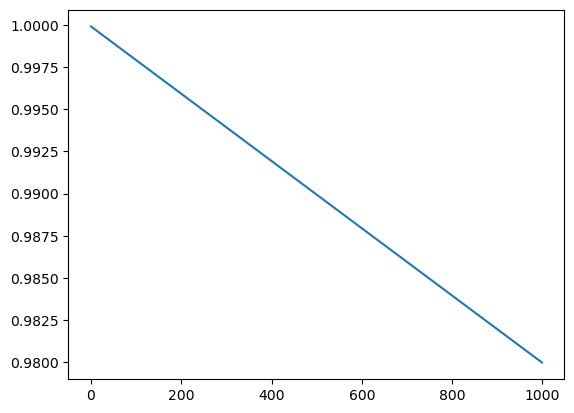

In [8]:
plt.plot(alpha);

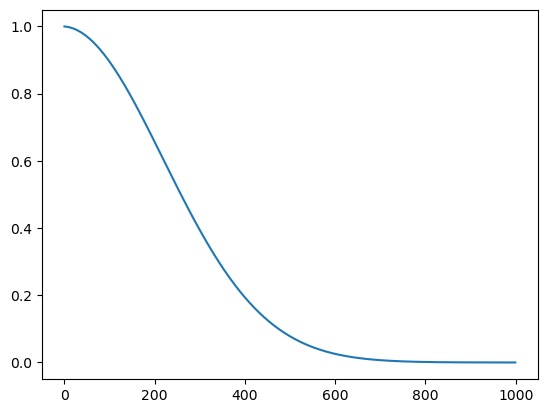

In [11]:
plt.plot(alpha_bar);

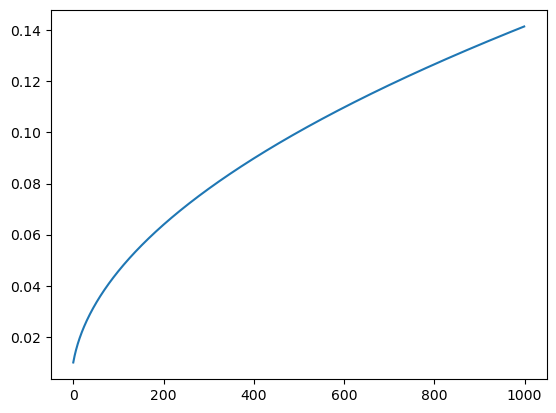

In [12]:
plt.plot(sigma);

In [16]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [17]:
(xt, t), ε = noisify(xb[:25], alpha_bar)
t

tensor([ 32, 864, 862, 180, 938, 271, 382, 174, 631, 443, 691, 481, 208, 915,
        615, 637, 491, 946, 240, 138, 626,   0, 253, 134, 704])

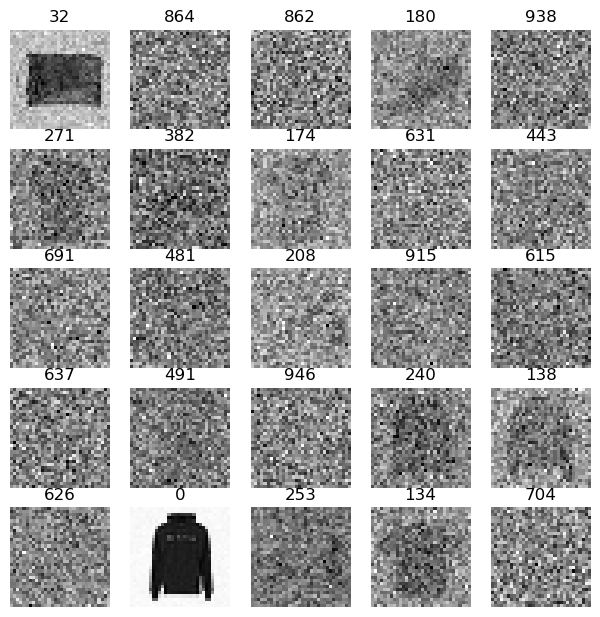

In [18]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)